In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
import pandas as pd
from ema_pytorch import EMA
from torch.distributions import Normal 

In [2]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [154]:
class ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_dist):
        super().__init__()

        self.marginal_prob_dist = marginal_prob_dist
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        
        self.mlp = nn.Sequential(
            nn.Linear(3, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, self.hidden_units, bias=True),
            nn.GELU(),
            nn.Linear(self.hidden_units, 2, bias=True)
        )
        self.l1 = nn.Linear(2, self.hidden_units, bias=True)
        self.emb1 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        #self.l5 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        #self.emb5 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 2, bias=True)
        
        
        #self.act = lambda x: x * torch.sigmoid(x)
        self.act=nn.GELU()
    def forward(self, x):
        t = x[:, 2]

        e = self.act(self.embed(t))    
        x = x[:,[0,1]]
        
        h1 = self.l1(x)
        h1+=self.emb1(e)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        h2+=self.emb2(e)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        h3+=self.emb3(e)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        h4+=self.emb4(e)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)
        
        
        #x = self.mlp(x)
        mean_coeff, sd = self.marginal_prob_dist(t)
        h5 = h5 / sd[:, None]
        return h5

In [4]:
def marginal_prob_dist(t, beta_min, beta_max):
    t_squared = torch.pow(t, 2)
    mean_coeff = torch.exp(-1/4 * t_squared * (beta_max - beta_min) - 1/2 * t * beta_min)
    sd = 1 - torch.exp(-1/2 * t_squared * (beta_max - beta_min) - t * beta_min)
    return mean_coeff, sd

def beta_t(t, beta_min, beta_max):
    return beta_min + t*(beta_max - beta_min)

beta_min = 0.1
beta_max = 20

marginal_prob_dist_fn = functools.partial(marginal_prob_dist, beta_min=beta_min, beta_max=beta_max)
beta_t_fn = functools.partial(beta_t, beta_min=beta_min, beta_max=beta_max)

In [5]:
def loss_fn(model, x, marginal_prob_dist_fn, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the mean and standard deviation of the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    mean_coeff, std = marginal_prob_dist_fn(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn_like(x)
    perturbed_x = x * mean_coeff[:, None] + z * std[:, None]
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    score = model(x_with_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=0))
    return loss

In [6]:
y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
x = np.tanh(y) + z
ex_1 = torch.vstack([x, y]).T

y = -6 * torch.rand(100000) + 3
z = np.random.normal(0,np.sqrt(0.05), size = 100000)
x = torch.tanh(y+z)
ex_2 = torch.vstack([x, y]).T

y = -6 * torch.rand(100000) + 3
z = np.random.gamma(1,0.3, size = 100000)
z = torch.tensor(z)
x = z*torch.tanh(y)
ex_3 = torch.vstack([x, y]).T

In [155]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
ema = EMA(
    score_model,
    beta = 0.9999,              # exponential moving average factor
    update_after_step = 100,    # only after this number of .update() calls will it start updating
    update_every = 10,   # how often to actually update, to save on compute (updates every 10th .update() call)
    include_online_model = False
)

optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        ema.update()
        
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    torch.save(score_model.state_dict(), 'models/ddpm_ex_1.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

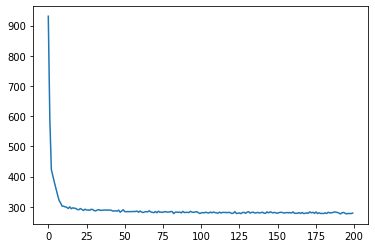

In [156]:
plt.plot(losses)

In [157]:
sum(p.numel() for p in score_model.parameters())

46500

In [162]:
num_steps =  1000
signal_to_noise_ratio = 0.16
def pc_sampler(score_model, marginal_prob_dist, beta_t, 
               batch_size=1000, num_steps=num_steps, eps=5e-2, snr = signal_to_noise_ratio):
    
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    xs = [x]
    
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  
            
            # Predictor step
            score = score_model(x_with_t)
            mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None]) * torch.randn_like(x)  
            xs.append(x)
    # Do not include any noise in the last sampling step.
    return mean_x, xs

In [163]:
def pc_ema_sampler(score_model, marginal_prob_dist, beta_t, 
               batch_size=1000, num_steps=num_steps, eps=5e-2, snr = signal_to_noise_ratio):
    
    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    xs = [x]
    
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  
            
            # Predictor step
            score = score_model(x_with_t)
            mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None]) * torch.randn_like(x)  
            xs.append(x)
    # Do not include any noise in the last sampling step.
    return mean_x

In [160]:
def density_plot(sample):
    df = pd.DataFrame(sample.numpy())
    df.columns =['x1', 'x2']
    sns.displot(df, x ='x1', y='x2', kind="kde")

In [170]:
score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
ckpt = torch.load('models/ddpm_ex_1.pth')
score_model.load_state_dict(ckpt)
pc_samples, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn,batch_size=5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [171]:
pc_ema_samples = pc_ema_sampler(ema, 
                  marginal_prob_dist_fn,
                  beta_t_fn,batch_size=5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

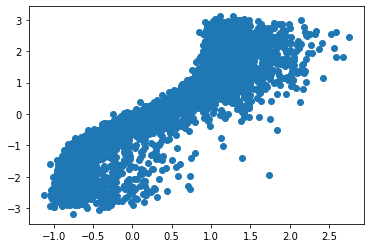

In [172]:
plt.scatter(pc_samples[:,0], pc_samples[:,1])

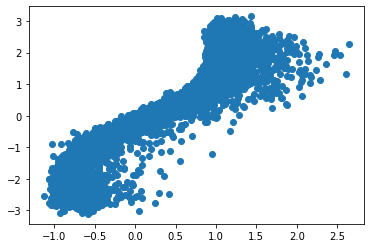

In [173]:
plt.scatter(pc_ema_samples[:,0], pc_ema_samples[:,1])

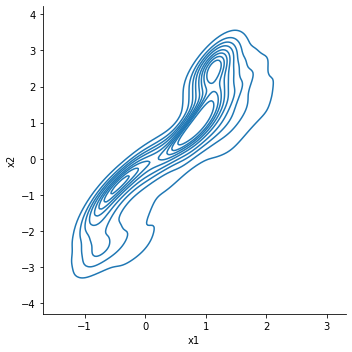

In [174]:
density_plot(pc_samples)

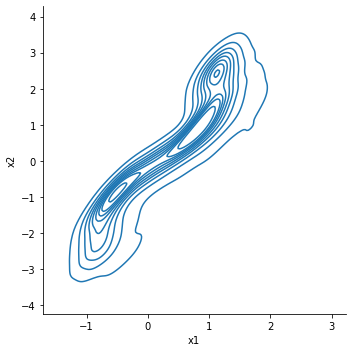

In [175]:
density_plot(pc_ema_samples)

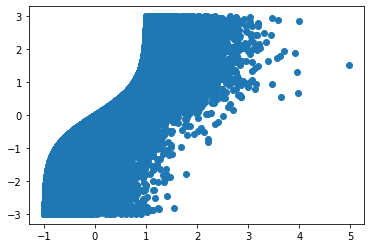

In [106]:
plt.scatter(ex_1[:,0], ex_1[:,1])

In [199]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_ex_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

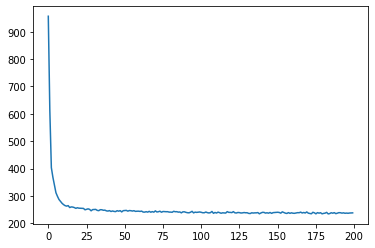

In [200]:
plt.plot(losses)

In [203]:
ckpt = torch.load('models/ddpm_ex_2.pth')
score_model.load_state_dict(ckpt)
pc_samples_2, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn,batch_size=5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

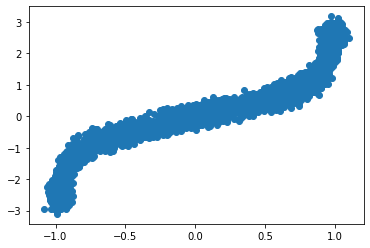

In [204]:
plt.scatter(pc_samples_2[:,0], pc_samples_2[:,1])

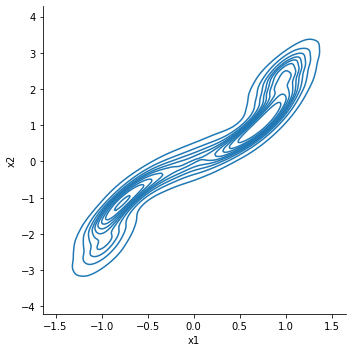

In [205]:
density_plot(pc_samples_2)

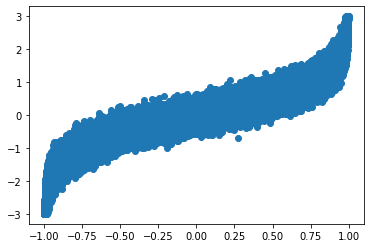

In [54]:
plt.scatter(ex_2[:,0], ex_2[:,1])

In [206]:
epochs = 200
batch_size = 1000
lr=1e-4

score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_ex_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/200 [00:00<?, ?it/s]

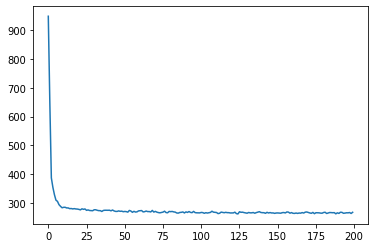

In [207]:
plt.plot(losses)

In [210]:
ckpt = torch.load('models/ddpm_ex_3.pth')
score_model.load_state_dict(ckpt)
pc_samples_3, xs= pc_sampler(score_model, 
                  marginal_prob_dist_fn,
                  beta_t_fn, batch_size=5000)

  0%|          | 0/1000 [00:00<?, ?it/s]

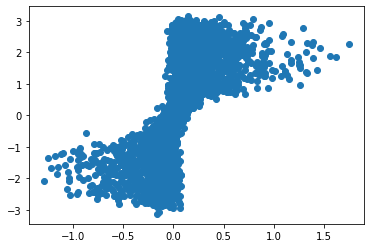

In [211]:
plt.scatter(pc_samples_3[:,0], pc_samples_3[:,1])

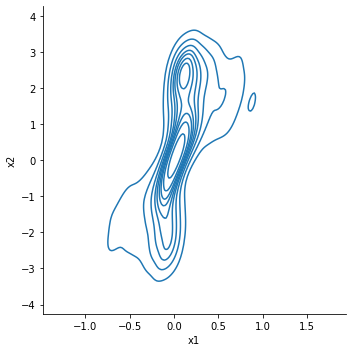

In [212]:
density_plot(pc_samples_3)

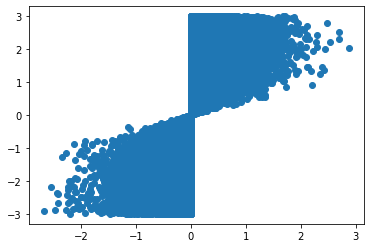

In [64]:
plt.scatter(ex_3[:,0], ex_3[:,1])

In [15]:
actual_samples_pos = np.random.gamma(1,0.3, size = 100000) + np.tanh(1.2)
actual_samples_0 = np.random.gamma(1,0.3, size = 100000) + np.tanh(0)
actual_samples_neg = np.random.gamma(1,0.3, size = 100000) + np.tanh(-1.2)

In [16]:
actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 100000) - 1.2)

In [17]:
actual_samples_pos_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(1.2)
actual_samples_neg_3 = np.random.gamma(1,0.3, size=100000) * np.tanh(-1.2)

In [213]:
def get_diffused_y(y_obs, timesteps):
    timesteps = torch.flip(timesteps, [0])
    mean_coeff, sd = marginal_prob_dist_fn(timesteps)
    mean_coeff  = mean_coeff[:,None]
    sd = sd[:,None]
    diffused_y = y_obs*mean_coeff + torch.randn(timesteps.shape[0], 1) * sd

    return diffused_y

In [214]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDiffE_pc_sampler(score_model, 
               marginal_prob_dist,
               beta_t,
               y_obs,
               batch_size=1000, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=5e-2):

    t = torch.ones(batch_size)
    init_x = torch.randn(batch_size, 2)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    diffused_y = [i.repeat(batch_size).reshape(batch_size,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]

            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            x_with_t = torch.hstack([x, batch_time_step_])
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            score = score_model(x_with_t)
            mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
            x = mean_x + torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None]) * torch.randn_like(x)  
            
    # The last step does not include any noise
    return mean_x

In [194]:
ckpt = torch.load('models/ddpm_ex_1.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples_0 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_neg = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_pos = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

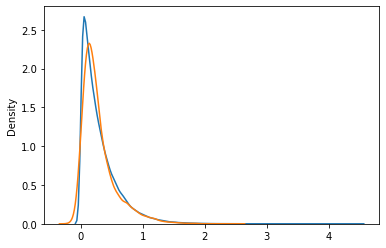

In [195]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cdiffe_samples_0[:,0])

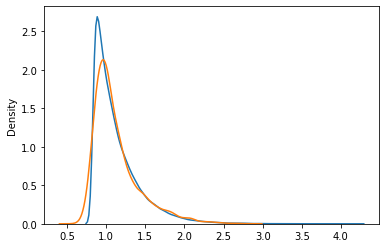

In [196]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cdiffe_samples_pos[:,0])

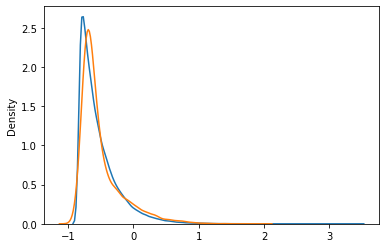

In [197]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cdiffe_samples_neg[:,0])

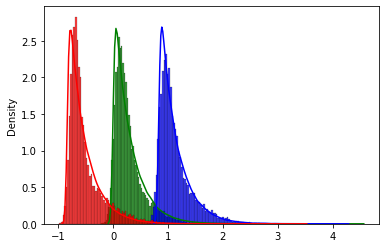

In [198]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

In [220]:
ckpt = torch.load('models/ddpm_ex_2.pth')
score_model.load_state_dict(ckpt)
cdiffe_samples_0_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_neg_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_pos_2 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

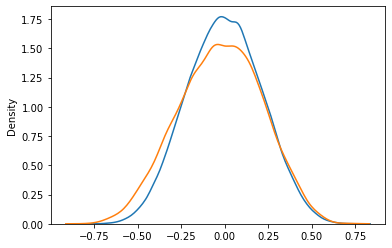

In [221]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cdiffe_samples_0_2[:,0])

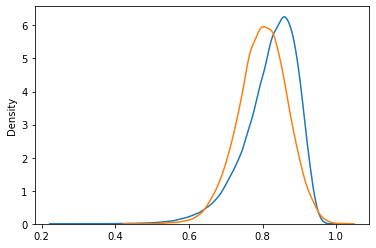

In [222]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cdiffe_samples_pos_2[:,0])

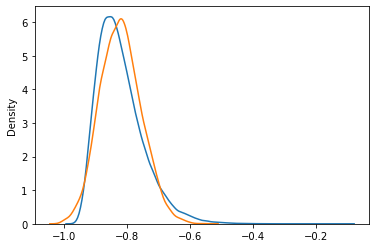

In [223]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cdiffe_samples_neg_2[:,0])

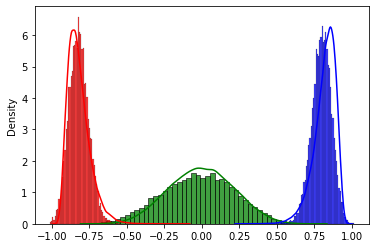

In [224]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

In [229]:
ckpt = torch.load('models/ddpm_ex_3.pth')
score_model.load_state_dict(ckpt)

cdiffe_samples_neg_3 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 10000)
cdiffe_samples_pos_3 = CDiffE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

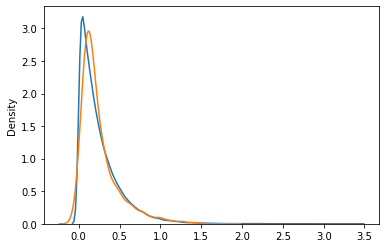

In [230]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cdiffe_samples_pos_3[:,0])

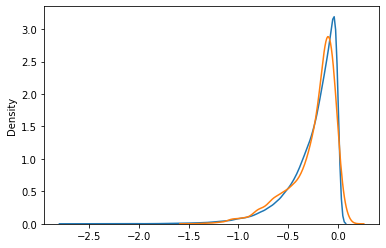

In [231]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cdiffe_samples_neg_3[:,0])

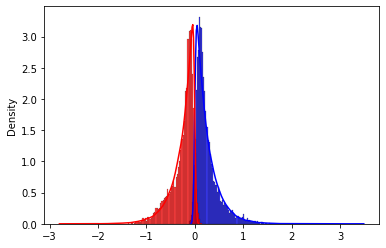

In [232]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

In [233]:
def SMCDiff_pc_sampler(score_model, marginal_prob_dist, beta_t, y_obs, k, 
                                   snr=signal_to_noise_ratio, num_steps=1000, eps=5e-2):

    t = torch.ones(k)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    weights = np.ones(k)/k
    xs = []
    init_x = torch.randn(k, 2)
    xs.append(init_x)
    diffused_y = [i.repeat(k).reshape(k,1) for i in get_diffused_y(y_obs, time_steps)]
    
    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            batch_time_step = torch.ones(k) * time_step
            y_obs_t = diffused_y[idx]
            x = xs[-1]
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            
            #corrector step (Langevin MCMC)
            batch_time_step_ = torch.reshape(torch.ones(k) * time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)
            
            x = torch.hstack([x,y_obs_t])[:, [0,2]]
            x_with_t = torch.hstack([x, batch_time_step_])
            
            #get predicted y_{t-1}
            if (idx - 1) >= 0:
                score = score_model(x_with_t)
                mean_x = x + (1/2 * beta_t(t=batch_time_step)[:,None] + beta_t(t=batch_time_step)[:,None] * score) * step_size
                sd = torch.sqrt(step_size) * torch.sqrt(beta_t(t=batch_time_step)[:,None])
                y_update_mean = mean_x[:,1]
                #get probability of this compared to actual y_{t-1}
                y_update_actual = diffused_y[idx-1].flatten()

                # compute un-normalized weighting factor for importance resampling step
                #log_w = get_log_w(y_update_actual.reshape(k, 1), y_update_mean.reshape(k,1))
                log_w = log_normal_density(y_update_actual, y_update_mean, sd.flatten())
                log_w -= torch.logsumexp(log_w, 0)
                

                # Update Self-normalized importance weights
                weights = torch.exp(log_w).cpu().detach().numpy()

                weights /= sum(weights) # Re-normalize
                
                #print(weights)
                #print(np.argsort(weights))
                
                resample_index = systematic(weights, k)
                #resample_index = np.random.default_rng().choice([i for i in range(k)], size=k, p=weights)
                x = x[resample_index]
                #print(np.argsort(weights))
                #print(sorted(resample_index))
                
                weights = np.ones_like(weights)
            
            x_with_t = torch.hstack([x, batch_time_step_])
            score = score_model(x_with_t)
            b = beta_t(t=batch_time_step)[:,None]
            mean_x = x + (1/2 * b + b * score) * step_size
            x_t_1 = mean_x + torch.sqrt(step_size) * torch.sqrt(b) * torch.randn_like(x)  
            
            xs.append(x_t_1)

    return mean_x

In [234]:
def get_log_w(y, mean):
    norm = np.linalg.norm(y-mean, axis=1)
    return -torch.pow(torch.tensor(norm),2)

In [235]:
def log_normal_density(sample, mean, sd):
    return Normal(loc=mean, scale=sd).log_prob(sample)

In [236]:
def inverse_cdf(su, W):
    """Inverse CDF algorithm for a finite distribution.

        Parameters
        ----------
        su: (M,) ndarray
            M sorted uniform variates (i.e. M ordered points in [0,1]).
        W: (N,) ndarray
            a vector of N normalized weights (>=0 and sum to one)

        Returns
        -------
        A: (M,) ndarray
            a vector of M indices in range 0, ..., N-1
    """
    j = 0
    s = W[0]
    M = su.shape[0]
    A = np.empty(M, dtype=np.int64)
    for n in range(M):
        while su[n] > s:
            if j <W.shape[0]-1:
                j += 1
            s += W[j]
        A[n] = j
    return A

def multinomial(W, M):
    """Multinomial resampling.

    Popular resampling scheme, which amounts to sample N independently from
    the multinomial distribution that generates n with probability W^n. 

    This resampling scheme is *not* recommended for various reasons; basically
    schemes like stratified / systematic / SSP tends to introduce less noise,
    and may be faster too (in particular systematic). 
    """
    return inverse_cdf(uniform_spacings(M), W)

def uniform_spacings(N):
    """Generate ordered uniform variates in O(N) time.

    Parameters
    ----------
    N: int (>0)
        the expected number of uniform variates

    Returns
    -------
    (N,) float ndarray
        the N ordered variates (ascending order)

    Note
    ----
    This is equivalent to::

        from numpy import random
        u = sort(random.rand(N))

    but the line above has complexity O(N*log(N)), whereas the algorithm
    used here has complexity O(N).

    """
    z = np.cumsum(-np.log(np.random.rand(N + 1)))
    return z[:-1] / z[-1]

def residual(W):
    """Residual resampling.
    """
    N = W.shape[0]
    M = N
    A = np.empty(M, dtype=np.int64)
    MW = M * W
    intpart = np.floor(MW).astype(np.int64)
    sip = np.sum(intpart)
    res = MW - intpart
    sres = M - sip
    A[:sip] = np.arange(N).repeat(intpart)
    # each particle n is repeated intpart[n] times
    if sres > 0:
        A[sip:] = multinomial(res / sres, M=sres)
    return A

def systematic(W, M):
    """Systematic resampling.
    """
    su = (np.random.rand(1) + np.arange(M)) / M
    return inverse_cdf(su, W)

In [134]:
ckpt = torch.load('models/ddpm_ex_1.pth')
score_model.load_state_dict(ckpt)

SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 10)

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[-0.0029,  0.0162],
        [ 0.1911,  0.0169],
        [ 0.2113,  0.0169],
        [ 0.2671,  0.0170],
        [-0.1144,  0.0155],
        [ 0.3224,  0.0171],
        [-0.2515,  0.0144],
        [ 0.1713,  0.0168],
        [ 0.0270,  0.0163],
        [ 0.2916,  0.0170]])

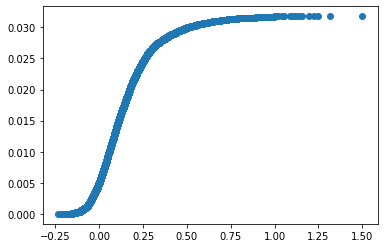

In [266]:
plt.scatter(sorted(smcdiff_samples_0[:,0]), sorted(actual_samples_0)[:10000])

In [243]:
score_model = ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
ckpt = torch.load('models/ddpm_ex_1.pth')
score_model.load_state_dict(ckpt)

smcdiff_samples_0 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 10000)

smcdiff_samples_pos = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 10000)

smcdiff_samples_neg = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

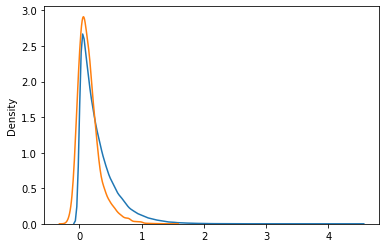

In [244]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(smcdiff_samples_0[:,0])

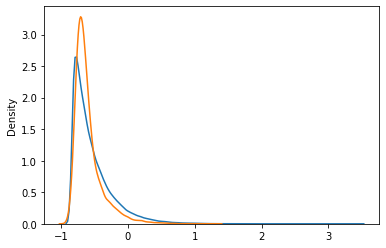

In [245]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(smcdiff_samples_neg[:,0])

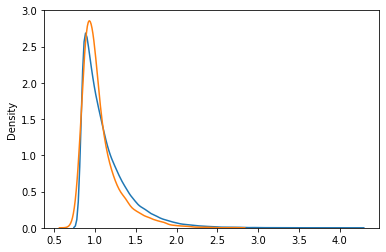

In [246]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(smcdiff_samples_pos[:,0])

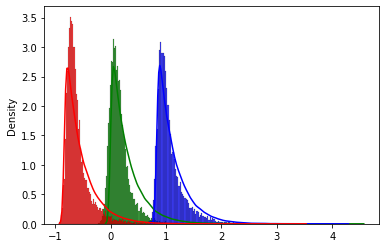

In [267]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(smcdiff_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(smcdiff_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(smcdiff_samples_neg[:,0], stat = 'density', color = 'red')

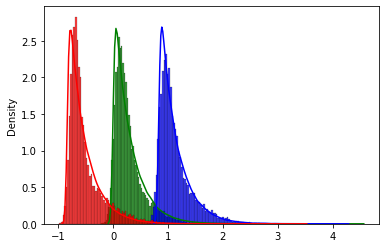

In [268]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cdiffe_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cdiffe_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cdiffe_samples_neg[:,0], stat = 'density', color = 'red')

In [254]:
ckpt = torch.load('models/ddpm_ex_2.pth')
score_model.load_state_dict(ckpt)
smcdiff_samples_0_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), k = 10000)

smcdiff_samples_pos_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 10000)

smcdiff_samples_neg_2 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

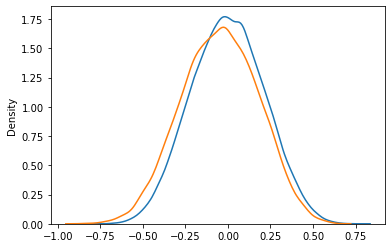

In [255]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(smcdiff_samples_0_2[:,0])

In [274]:
torch.mean(smcdiff_samples_0_2[:,0])

tensor(-0.0490)

In [273]:
np.mean(actual_samples_0_2)

-0.0013667207867152347

In [275]:
torch.mean(cdiffe_samples_0_2[:,0])

tensor(-0.0244)

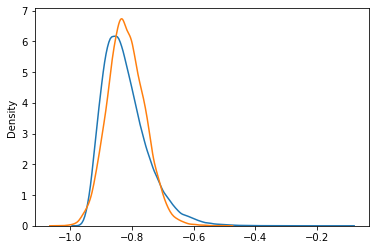

In [256]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(smcdiff_samples_neg_2[:,0])

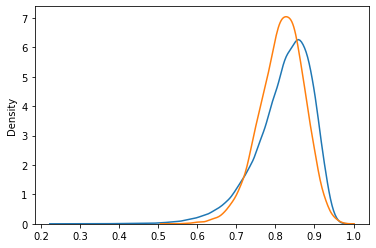

In [257]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(smcdiff_samples_pos_2[:,0])

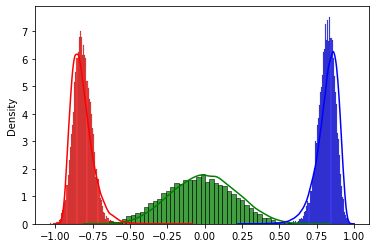

In [269]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(smcdiff_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(smcdiff_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(smcdiff_samples_neg_2[:,0], stat = 'density', color = 'red')

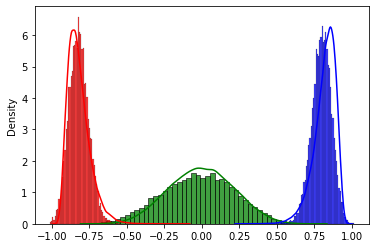

In [270]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cdiffe_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cdiffe_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cdiffe_samples_neg_2[:,0], stat = 'density', color = 'red')

In [260]:
ckpt = torch.load('models/ddpm_ex_3.pth')
score_model.load_state_dict(ckpt)

smcdiff_samples_pos_3 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), k = 10000)

smcdiff_samples_neg_3 = SMCDiff_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), k = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

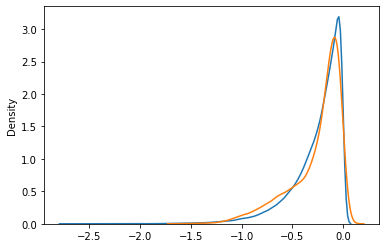

In [261]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(smcdiff_samples_neg_3[:,0])

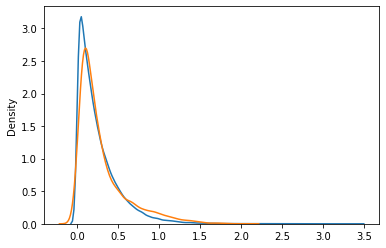

In [262]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(smcdiff_samples_pos_3[:,0])

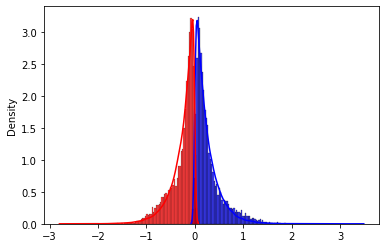

In [263]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(smcdiff_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(smcdiff_samples_neg_3[:,0], stat = 'density', color = 'red')

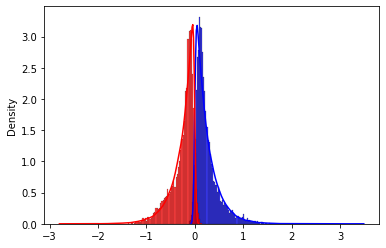

In [264]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cdiffe_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cdiffe_samples_neg_3[:,0], stat = 'density', color = 'red')

In [419]:
class cde_ScoreNet(nn.Module):
    
    def __init__(self, marginal_prob_dist):
        super().__init__()

        self.marginal_prob_dist = marginal_prob_dist
        self.hidden_units = 64
        # inputs of data (x,y), timestep t
        self.embed_t = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        
        self.embed_y = nn.Sequential(GaussianFourierProjection(embed_dim=self.hidden_units), 
                                   nn.Linear(self.hidden_units, self.hidden_units))
        
        self.l1 = nn.Linear(1, self.hidden_units, bias=True)
        self.emb1_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb1_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l2 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb2_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l3 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb3_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l4 = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4_t = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.emb4_y = nn.Linear(self.hidden_units, self.hidden_units, bias=True)
        self.l5 = nn.Linear(self.hidden_units, 1, bias=True)
        self.act=nn.GELU()
        
    def forward(self, x):
        t = x[:, 2]
        y = x[:, 1]
        x = x[:,0].reshape(x.shape[0],1)
        
        t_emb = self.act(self.embed_t(t)) 
        y_emb = self.act(self.embed_y(y)) 
        
        h1 = self.l1(x)
        h1+=self.emb1_t(t_emb)
        h1+=self.emb1_y(y_emb)
        h1 = self.act(h1)
        
        h2 = self.l2(h1)
        h2+=self.emb2_t(t_emb)
        h2+=self.emb2_y(y_emb)
        h2 = self.act(h2)
        
        h3 = self.l3(h2)
        h3+=self.emb3_t(t_emb)
        h3+=self.emb3_y(y_emb)
        h3 = self.act(h3)
        
        h4 = self.l4(h3)
        h4+=self.emb4_t(t_emb)
        h4+=self.emb4_y(y_emb)
        h4 = self.act(h4)
        
        h5 = self.l5(h4)

        mean_coeff, sd = self.marginal_prob_dist(t)
        h5 = h5 / sd[:, None]
        return h5

In [358]:
def CDE_loss_fn(model, x, marginal_prob_dist, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    y = torch.reshape(x[:,1], (x.shape[0], 1))
    random_t = torch.rand(x.shape[0]) * (1. - eps) + eps  
    mean_coeff, std = marginal_prob_dist(random_t)
    random_t = torch.reshape(random_t, (x.shape[0], 1))
    z = torch.randn(((x.shape[0], 1)))
    perturbed_x = mean_coeff.flatten() * x[:,0].flatten() + z.flatten() * std.flatten()
    #print(perturbed_x)
    perturbed_x = torch.hstack([perturbed_x.reshape(x.shape[0], 1),y])
    
    x_with_t = torch.hstack([perturbed_x,random_t])
    x_with_t = x_with_t.to(torch.float32)
    
    score = model(x_with_t).flatten()
    #print(score)
    loss = torch.mean(torch.sum((score * std.flatten() + z.flatten())**2, dim=0))
    return loss

In [427]:
signal_to_noise_ratio = 0.16
num_steps =  1000

def CDE_pc_sampler(score_model, 
               marginal_prob_dist,
               beta_t,
               y_obs,
               batch_size=2048, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,
               eps=5e-2):

    init_x = torch.randn(batch_size, 1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    y_obs = y_obs.repeat(batch_size)
    y_obs = y_obs.reshape(batch_size,1)
    x = torch.hstack([init_x, y_obs])
    with torch.no_grad():
        for time_step in notebook.tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size) * time_step
            batch_time_step_ = torch.reshape(batch_time_step, (x.shape[0], 1))
            x_with_t = torch.hstack([x, batch_time_step_])
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x_with_t)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            
            score = score_model(x_with_t)
            b = beta_t(t=batch_time_step)[:,None]
            mean_x = x + (1/2 * b + b * score) * step_size
            x_t_1 = mean_x + torch.sqrt(step_size) * torch.sqrt(b) * torch.randn_like(x)  
            
            #conditional info
            x = torch.hstack([x,y_obs])
            x = x[:, [0,2]]

    # The last step does not include any noise
    return mean_x

In [420]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = cde_ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_1
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_cde_1.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

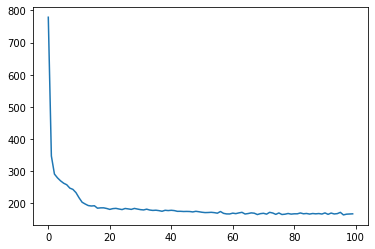

In [421]:
plt.plot(losses)

In [433]:
ckpt = torch.load('models/ddpm_cde_1.pth')
score_model.load_state_dict(ckpt)
cde_samples_0 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 10000)
cde_samples_pos = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 10000)
cde_samples_neg = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 10000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

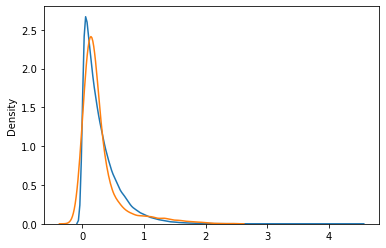

In [434]:
sns.kdeplot(actual_samples_0)
sns.kdeplot(cde_samples_0[:,0])

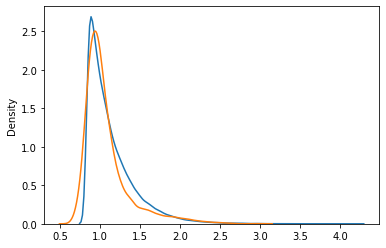

In [435]:
sns.kdeplot(actual_samples_pos)
sns.kdeplot(cde_samples_pos[:,0])

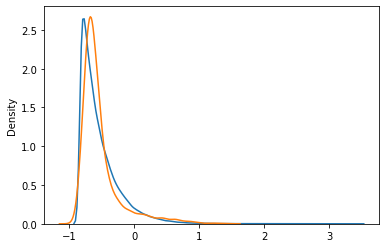

In [436]:
sns.kdeplot(actual_samples_neg)
sns.kdeplot(cde_samples_neg[:,0])

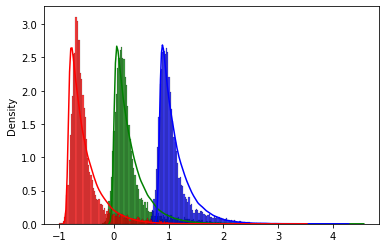

In [437]:
sns.kdeplot(actual_samples_0, color = 'green')
sns.histplot(cde_samples_0[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos, color = 'blue')
sns.histplot(cde_samples_pos[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg, color = 'red')
sns.histplot(cde_samples_neg[:,0], stat = 'density', color = 'red')

In [438]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = cde_ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_2
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_cde_2.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

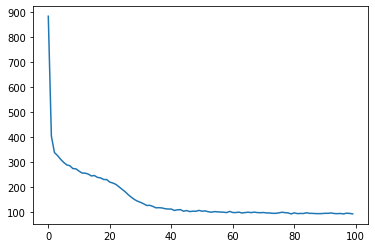

In [439]:
plt.plot(losses)

In [489]:
ckpt = torch.load('models/ddpm_cde_2.pth')
score_model.load_state_dict(ckpt)
cde_samples_0_2 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(0, dtype = torch.float32), batch_size = 1000, eps=8e-2)
cde_samples_pos_2 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000,eps=8e-2)
cde_samples_neg_2 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000,eps=8e-2)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

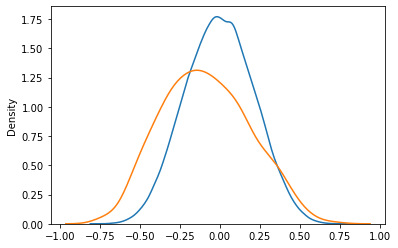

In [490]:
sns.kdeplot(actual_samples_0_2)
sns.kdeplot(cde_samples_0_2[:,0])

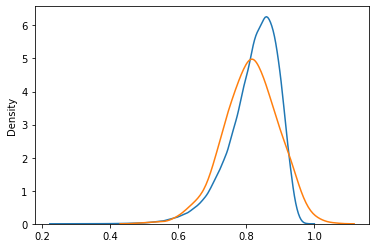

In [491]:
sns.kdeplot(actual_samples_pos_2)
sns.kdeplot(cde_samples_pos_2[:,0])

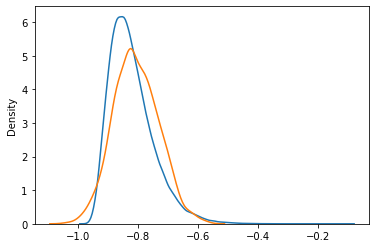

In [492]:
sns.kdeplot(actual_samples_neg_2)
sns.kdeplot(cde_samples_neg_2[:,0])

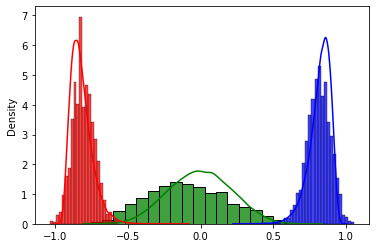

In [493]:
sns.kdeplot(actual_samples_0_2, color = 'green')
sns.histplot(cde_samples_0_2[:,0], stat = 'density', color = 'green')
sns.kdeplot(actual_samples_pos_2, color = 'blue')
sns.histplot(cde_samples_pos_2[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_2, color = 'red')
sns.histplot(cde_samples_neg_2[:,0], stat = 'density', color = 'red')

In [445]:
epochs = 100
batch_size = 1000
lr=1e-4

score_model = cde_ScoreNet(marginal_prob_dist=marginal_prob_dist_fn)
optimizer = Adam(score_model.parameters(), lr=lr)
dataset = ex_3
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
tqdm_epoch = notebook.trange(epochs)
losses = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x in data_loader:
        loss = CDE_loss_fn(score_model, x, marginal_prob_dist_fn)
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'models/ddpm_cde_3.pth')
    losses.append(avg_loss / num_items)

  0%|          | 0/100 [00:00<?, ?it/s]

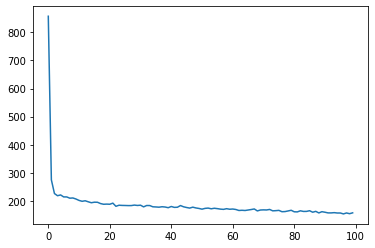

In [446]:
plt.plot(losses)

In [470]:
ckpt = torch.load('models/ddpm_cde_3.pth')
score_model.load_state_dict(ckpt)

cde_samples_pos_3 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(1.2, dtype = torch.float32), batch_size = 1000, eps=8e-2)
cde_samples_neg_3 = CDE_pc_sampler(score_model, 
                           marginal_prob_dist_fn,
                           beta_t_fn, 
                           y_obs = torch.tensor(-1.2, dtype = torch.float32), batch_size = 1000,eps=8e-2)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

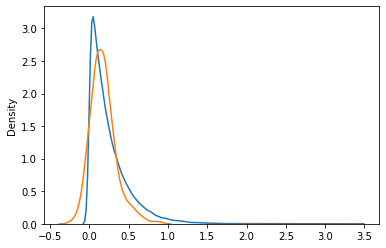

In [471]:
sns.kdeplot(actual_samples_pos_3)
sns.kdeplot(cde_samples_pos_3[:,0])

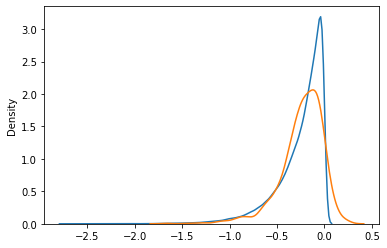

In [472]:
sns.kdeplot(actual_samples_neg_3)
sns.kdeplot(cde_samples_neg_3[:,0])

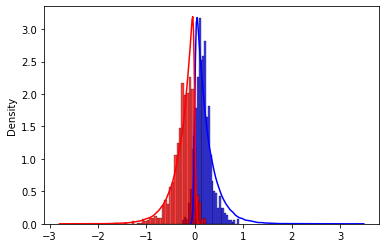

In [473]:
sns.kdeplot(actual_samples_pos_3, color = 'blue')
sns.histplot(cde_samples_pos_3[:,0], stat = 'density', color = 'blue')
sns.kdeplot(actual_samples_neg_3, color = 'red')
sns.histplot(cde_samples_neg_3[:,0], stat = 'density', color = 'red')

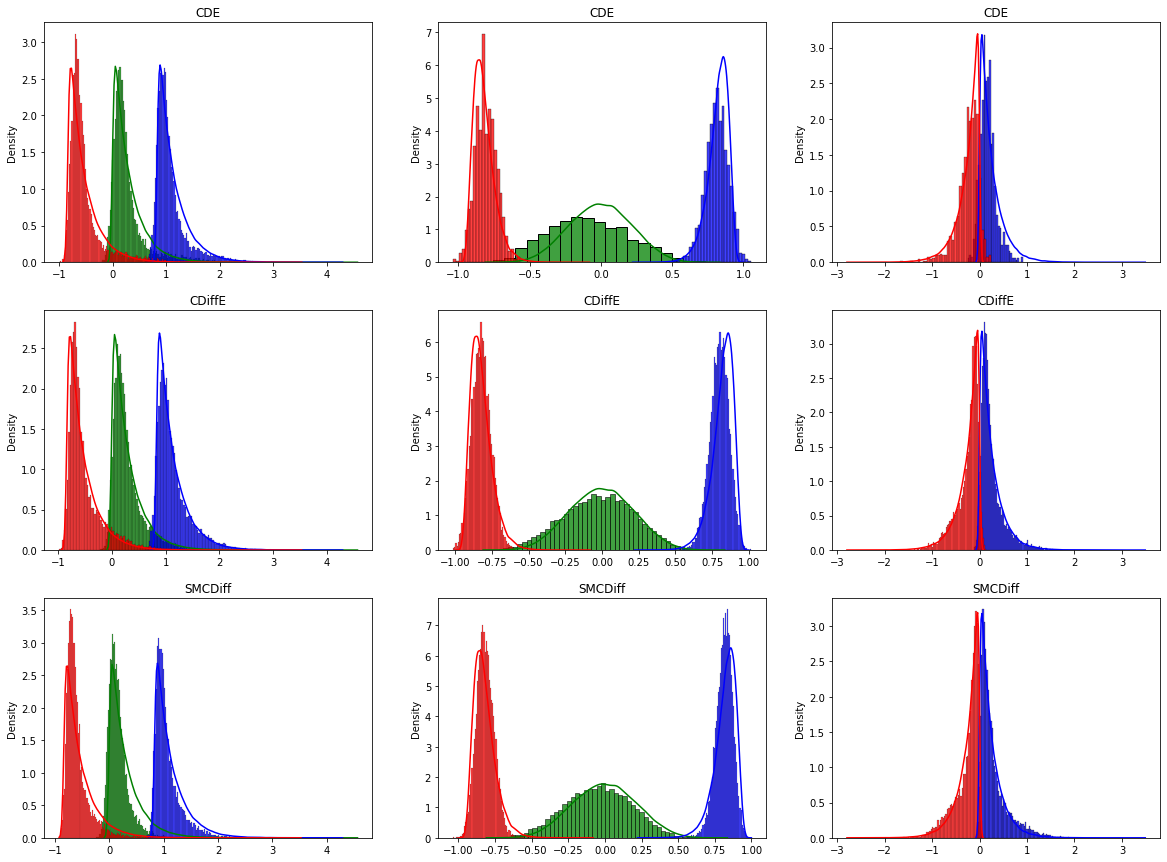

In [494]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))

def plot_row(s1,s2,s3,s4,s5,s6,s7,s8,row,title):
    sns.kdeplot(actual_samples_0, color = 'green', ax = axs[row,0])
    sns.histplot(s1[:,0], stat = 'density', color = 'green', ax = axs[row,0])
    sns.kdeplot(actual_samples_pos, color = 'blue', ax = axs[row,0])
    sns.histplot(s2[:,0], stat = 'density', color = 'blue', ax = axs[row,0])
    sns.kdeplot(actual_samples_neg, color = 'red', ax = axs[row,0])
    sns.histplot(s3[:,0], stat = 'density', color = 'red', ax = axs[row,0])

    sns.kdeplot(actual_samples_0_2, color = 'green', ax = axs[row,1])
    sns.histplot(s4[:,0], stat = 'density', color = 'green', ax = axs[row,1])
    sns.kdeplot(actual_samples_pos_2, color = 'blue', ax = axs[row,1])
    sns.histplot(s5[:,0], stat = 'density', color = 'blue', ax = axs[row,1])
    sns.kdeplot(actual_samples_neg_2, color = 'red', ax = axs[row,1])
    sns.histplot(s6[:,0], stat = 'density', color = 'red', ax = axs[row,1])

    sns.kdeplot(actual_samples_pos_3, color = 'blue', ax = axs[row,2])
    sns.histplot(s7[:,0], stat = 'density', color = 'blue', ax = axs[row,2])
    sns.kdeplot(actual_samples_neg_3, color = 'red', ax = axs[row,2])
    sns.histplot(s8[:,0], stat = 'density', color = 'red', ax = axs[row,2])

    axs[row,0].set_title(title)
    axs[row,1].set_title(title)
    axs[row,2].set_title(title)
    
plot_row(cde_samples_0, cde_samples_pos, cde_samples_neg, 
         cde_samples_0_2, cde_samples_pos_2, cde_samples_neg_2,
         cde_samples_pos_3, cde_samples_neg_3, 0, 'CDE')

plot_row(cdiffe_samples_0, cdiffe_samples_pos, cdiffe_samples_neg, 
         cdiffe_samples_0_2, cdiffe_samples_pos_2, cdiffe_samples_neg_2,
         cdiffe_samples_pos_3, cdiffe_samples_neg_3, 1, 'CDiffE')

plot_row(smcdiff_samples_0, smcdiff_samples_pos, smcdiff_samples_neg, 
         smcdiff_samples_0_2, smcdiff_samples_pos_2, smcdiff_samples_neg_2,
         smcdiff_samples_pos_3, smcdiff_samples_neg_3, 2, 'SMCDiff')